In [25]:
import igraph
import networkx as nx
import numpy as np
import pandas as pd
import copy
from matplotlib import cm
import math


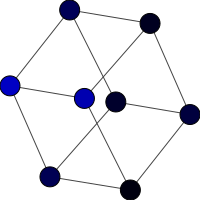

In [13]:
dim = [2, 4]
g = igraph.Graph.Lattice(dim, nei=1, directed=False, mutual=True, circular=True)
for v in g.vs: 
    r = np.random.rand() 
    v['nparticles'] = round(r*10)
    mycolor = list([0,0,r])
    v['color'] = mycolor
    
visual = {}
# visual["layout"] = g.layout('grid')
visual["bbox"] = (200, 200)
visual["margin"] = 10
igraph.plot(g, **visual)

In [29]:
outdir = '/tmp'
mapw = 2
maph = 3
dim = [mapw, maph]
g = igraph.Graph.Lattice(dim, nei=1, directed=False, mutual=True, circular=True)
nepochs = 20

s0 = 10
i0 = 1
r0 = 0
N = totalparticles = s0 + i0 + r0
beta = 0.5
gamma = 0.5

SUSCEPTIBLE = 0
INFECTED = 1
RECOVERED = 2

totalvertices = mapw*maph
status = np.ndarray(totalparticles, dtype=int)
status[0: s0] = SUSCEPTIBLE
status[s0:s0+i0] = INFECTED
status[s0+i0:] = RECOVERED
np.random.shuffle(status)

# Initialize  distribution of number of particles in the vertices
nparticles = np.ndarray(totalvertices)
for i in range(totalvertices):
    nparticles[i] = np.random.randint(10) # not quite random
    
nparticles = (nparticles / (np.sum(nparticles))*totalparticles).astype(int)
diff = totalparticles - np.sum(nparticles)

if diff > 0: incrementparticle = +1
elif diff <= 0: incrementparticle = -1

for i in range(diff):
    idx = np.random.randint(np.absolute(totalvertices))
    nparticles[idx] += 1 * incrementparticle

# Initialize distribution of particles (with status)
particles = [None]*totalvertices
k = 0
for i in range(totalvertices):
    particles[i] = list(range(k, k+nparticles[i]))
    k += nparticles[i]


############ set attractiviness
g.vs['attractiviness'] = 5
g.vs[1]['attractiviness'] = 1
g.vs[3]['attractiviness'] = 25

# print('Initial status:')
# print(status)
layout = g.layout()
########### Simulation
for ep in range(nepochs):
    ########### Mobility
    particles_fixed = copy.deepcopy(particles) # copy to avoid being altered

    
    for i, _ in enumerate(g.vs):
        numvparticles = len(particles_fixed[i])
        neighids = g.neighbors(i)
        attractiviness = g.vs[neighids]['attractiviness']
        attractiviness /= np.sum(attractiviness)

        for j, partic in enumerate(particles_fixed[i]): # For each particle in this vertex
            neighid = np.random.choice(neighids, p=attractiviness)
            particles[i].remove(partic)
            particles[neighid].append(partic)
  
    ########### SIR
    statuses_fixed = copy.deepcopy(status)
    for i, _ in enumerate(g.vs):
        statuses = statuses_fixed[particles[i]]
        susceptible = statuses[statuses==SUSCEPTIBLE]            
        infected = statuses[statuses==INFECTED]            
        recovered = statuses[statuses==RECOVERED]
#         ds = -beta * len(susceptible) * len(infected)
#         di = beta * len(susceptible) * len(infected) - gamma*len(infected)
#         dr = gamma*len(infected)
        numnewinfected = round(beta * len(susceptible) * len(infected))
        numnewrecovered = round(gamma*len(infected))
        indsusceptible = np.where(statuses_fixed==SUSCEPTIBLE)[0]
        indinfected = np.where(statuses_fixed==INFECTED)[0]
        indrecovered = np.where(statuses_fixed==RECOVERED)[0]

        if numnewinfected > 0: status[indsusceptible[0:numnewinfected]] = INFECTED  # I don't like this "if"
        if numnewrecovered > 0: status[indinfected[0:numnewrecovered]] = RECOVERED
   
    visual = {}
    # visual["layout"] = g.layout('grid')
    visual["bbox"] = (200, 200)
    visual["margin"] = 20

    nsusceptibles = np.array([ np.sum(status[particles[i]]==SUSCEPTIBLE) for i in range(totalvertices)] )
    ninfected = np.array([ np.sum(status[particles[i]]==INFECTED) for i in range(totalvertices)] )
    nrecovered = np.array([ np.sum(status[particles[i]]==RECOVERED) for i in range(totalvertices)] )
    
    susceptiblecolor = []
    infectedcolor = []
    recoveredcolor = []
    b = 100    
    for z in nsusceptibles:
        zz = [(math.log(z, b)/math.log(N, b)), 0, 0] if z != 0 else 0
        susceptiblecolor.append(zz)
    for z in ninfected:
        zz = [(math.log(z, b)/math.log(N, b)), 0, 0] if z != 0 else 0
        infectedcolor.append(zz)
    for z in nrecovered:
        zz = [(math.log(z, b)/math.log(N, b)), 0, 0] if z != 0 else 0
        recoveredcolor.append(zz)        
    # Save to files    
    outsusceptible = igraph.plot(g, layout=layout, vertex_label=nsusceptibles, vertex_color=susceptiblecolor, **visual)      
    outinfected = igraph.plot(g, layout=layout, vertex_label=ninfected, vertex_color=infectedcolor, **visual)      
    outrecovered = igraph.plot(g, layout=layout, vertex_label=nrecovered, vertex_color=recoveredcolor, **visual)      
    
    outsusceptible.save(os.path.join(outdir, 'susceptible{:02d}.png'.format(ep)))
    outinfected.save(os.path.join(outdir, 'infected{:02d}.png'.format(ep)))
    outrecovered.save(os.path.join(outdir, 'recovered{:02d}.png'.format(ep))

SyntaxError: invalid syntax (<ipython-input-29-3502b3a7615c>, line 121)